# Modeling the Incubator Temperature Dynamics

We will model the system of differential equations described in the incubator section, and simulate the temperature evolution inside the incubator over time. The Python code will follow these steps:
1. Define the system of ODEs based on the incubator temperature model.
2. Simulate the system using the `solve_ivp` method from `scipy.integrate`.
3. Visualize the temperature evolution of the heater and the box over time using `matplotlib`.

## Step 1: Define the ODE System for the Incubator

We'll model the system of differential equations from the incubator temperature model described by:
$$ 
C_{h} \frac{\mathrm dT_{h}}{\mathrm dt} = H_h \cdot P_h - G_{hb} \cdot (T_{h} - T_{b}) \\
C_{b} \frac{\mathrm dT_{b}}{\mathrm dt} = G_{hb} \cdot (T_{h} - T_{b}) - G_{br} \cdot (T_{b} - T_{r})
$$
Where:
- $ T_{h}(t) $ and $ T_{b}(t) $ are the heater and box temperatures.
- $ P_h $ is the electric power supplied to the heater, controlled by a Boolean switch $ H_h $.
- $T_{r}(t)$ is the room temperature (varying over time).

Let's define this system of ODEs in Python.

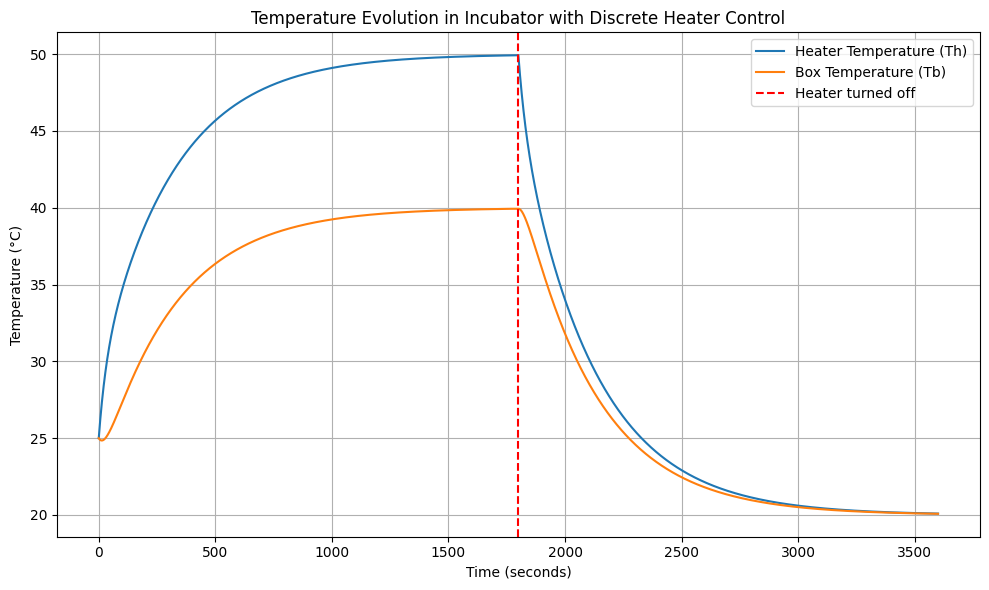

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the system of ODEs
def incubator_ode(t, y, Ch, Cb, Ph, G_hb, G_br, Tr, H_h):
    Th, Tb = y  # Unpack the state variables (heater temp, box temp)
    
    # Differential equations
    dTh_dt = (H_h * Ph - G_hb * (Th - Tb)) / Ch
    dTb_dt = (G_hb * (Th - Tb) - G_br * (Tb - Tr)) / Cb
    
    return [dTh_dt, dTb_dt]

# Parameters (arbitrary values for demonstration purposes)
Ch = 500.0  # Heat capacity of the heater (J/Kg/C)
Cb = 1000.0  # Heat capacity of the box (J/Kg/C)
Ph = 100.0  # Power supplied to the heater (W)
G_hb = 10.0  # Heat transfer coefficient between heater and box (W/C)
G_br = 5.0  # Heat transfer coefficient between box and room (W/C)
Tr = 20.0  # Room temperature (C). For this simulation we assume it is constant.
# Initial conditions
T_h0 = 25.0  # Initial heater temperature (C)
T_b0 = 25.0  # Initial box temperature (C)
y0 = [T_h0, T_b0]  # Initial state vector

# Define the simulation parameters
t_start = 0.0
t_end = 3600.0  # Simulate for 1 hour (3600 seconds)
time_step = 3.0  # Step size for each segment of the simulation. Think of this as the execution interval of the controller that turns on and off the heater.

# Arrays to store the results
t_values = []
Th_values = []
Tb_values = []

# Boolean switch for heater (turn on for the first half of the time span, off later)
def heater_switch(t):
    return 1 if t < 1800 else 0

# While-loop simulation with discrete heater switching
current_time = t_start
current_y = y0

while current_time < t_end:
    # Define the next time point for the step
    next_time = min(current_time + time_step, t_end)
    
    # Check the state of the heater switch. E.g., you could execute the controller state machine at this point.
    H_h = heater_switch(current_time)
    
    # Solve the ODE over this small time window
    sol = solve_ivp(
        lambda t, y: incubator_ode(t, y, Ch, Cb, Ph, G_hb, G_br, Tr, H_h),
        [current_time, next_time], current_y, t_eval=np.linspace(current_time, next_time, 10))
    
    # Store the results
    t_values.extend(sol.t)
    Th_values.extend(sol.y[0])
    Tb_values.extend(sol.y[1])
    
    # Update the current time and state for the next iteration
    current_time = next_time
    current_y = [sol.y[0][-1], sol.y[1][-1]]  # The last state becomes the new initial condition

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_values, Th_values, label='Heater Temperature (Th)')
plt.plot(t_values, Tb_values, label='Box Temperature (Tb)')
plt.axvline(x=1800, color='r', linestyle='--', label='Heater turned off')
plt.title('Temperature Evolution in Incubator with Discrete Heater Control')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Explanation of the Code

1. **Discrete Simulation in a While Loop**:
   - The simulation is now performed in a `while` loop, where each iteration advances the simulation by a fixed time step (`time_step = 3.0` seconds). Think of this as the execution interval of the controller that turns on and off the heater.
   - At each time step, the current state (`T_h`, `T_b`) is updated by solving the system of ODEs using `solve_ivp` over the current time window (`[current_time, next_time]`).

2. **Heater Switch**:
   - The `heater_switch(t)` function determines whether the heater is on or off based on the current time. The heater is on for the first 1800 seconds (`t < 1800`) and off afterward.

3. **Updating the State**:
   - After each call to `solve_ivp`, we update the state (`T_h`, `T_b`) with the final values of the current solution segment. These updated values are used as the initial condition for the next iteration of the loop.

4. **Storing and Plotting the Results**:
   - We store the time and temperature values (`t_values`, `Th_values`, and `Tb_values`) at each step, and once the loop is done, we plot the results.

The output plot will show two temperature curves:
- **Heater Temperature (`T_h`)**: The temperature of the heater increases when the heater is on, and starts to cool down when the heater is turned off at 1800 seconds.
- **Box Temperature (`T_b`)**: The temperature of the box follows a similar pattern but with a lag due to the thermal conductivity between the heater and the box.

Additionally, a red dashed line is plotted at 1800 seconds, indicating the point where the heater is turned off.

### Key Points
- The simulation runs step-by-step in a `while` loop, making it easy to handle discrete changes in the control inputs (like turning the heater on and off).
- You could also change room temperature over time following this approach.
- This approach provides fine-grained control over the simulation, allowing you to handle dynamic inputs and external events at each time step.

## Step 2: Extending the Model with Inputs Coming from A Dataset

Incorporating additional factors, such as fluctuating room temperature or varying electrical power, can be done by modifying the equations and adding additional logic to simulate different inputs.
Let's update the code to include the electrical heating power as a function that can change over time (e.g., using `numpy` interpolation), or the room temperature might also change dynamically.


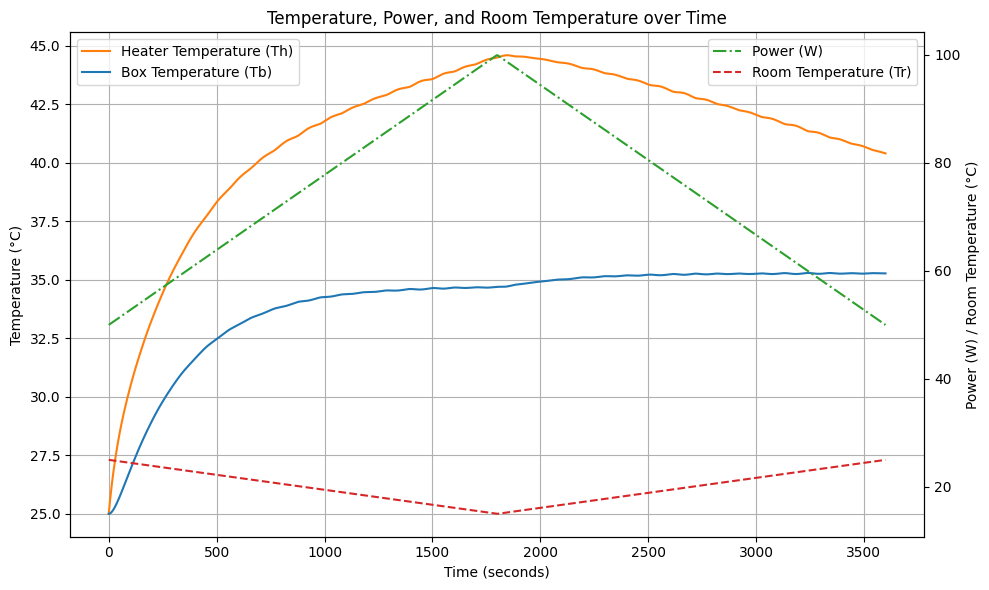

In [2]:
# Example of a varying power and room temperature
from scipy.interpolate import interp1d

# Define time-varying electrical power and room temperature (as example)
time_points = np.array([0, 1800, 3600])
power_points = np.array([50, 100, 50])  # Electrical power over time
room_temp_points = np.array([25, 15, 25])  # Room temperature fluctuates

# Interpolate the power and room temperature as continuous functions
power_interp = interp1d(time_points, power_points, kind='linear')
room_temp_interp = interp1d(time_points, room_temp_points, kind='linear')

# Updated ODE system with varying power and room temperature
def incubator_ode_with_varying_conditions(t, y, Ch, Cb, G_hb, G_br):
    Th, Tb = y
    Ph = power_interp(t)  # Interpolated power at time t
    Tr = room_temp_interp(t)  # Interpolated room temperature at time t
    H_h = 1.0  # Heater on/off switch - always on, as we're varying the power instead.
    dTh_dt = (H_h * Ph - G_hb * (Th - Tb)) / Ch
    dTb_dt = (G_hb * (Th - Tb) - G_br * (Tb - Tr)) / Cb
    return [dTh_dt, dTb_dt]

# Function to solve the ODEs using solve_ivp
def solve_incubator_with_varying_conditions():
    sol = solve_ivp(
        lambda t, y: incubator_ode_with_varying_conditions(t, y, Ch, Cb, G_hb, G_br),
        t_span, y0, t_eval=t_eval)
    return sol

# Parameters for the incubator system
Ch = 500.0  # Heat capacity of the heater (J/Kg/C)
Cb = 1000.0  # Heat capacity of the box (J/Kg/C)
G_hb = 10.0  # Heat transfer coefficient between heater and box (W/C)
G_br = 5.0  # Heat transfer coefficient between box and room (W/C)
y0 = [25.0, 25.0]  # Initial temperature conditions [Heater temperature, Box temperature]
t_span = (0, 3600)  # Simulate for 1 hour
t_eval = np.linspace(0, 3600, 1000)  # Time points for solution

# Solve the ODEs
solution_varying = solve_incubator_with_varying_conditions()

# Extract the results
t_values_varying = solution_varying.t
Th_values_varying = solution_varying.y[0]  # Heater temperature over time
Tb_values_varying = solution_varying.y[1]  # Box temperature over time

# Evaluate the power and room temperature using interpolation
power_values = power_interp(t_values_varying)
room_temp_values = room_temp_interp(t_values_varying)

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot heater and box temperatures on the primary y-axis
ax1.plot(t_values_varying, Th_values_varying, label='Heater Temperature (Th)', color='tab:orange')
ax1.plot(t_values_varying, Tb_values_varying, label='Box Temperature (Tb)', color='tab:blue')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Temperature (°C)')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a secondary y-axis for power and room temperature
ax2 = ax1.twinx()
ax2.plot(t_values_varying, power_values, label='Power (W)', color='tab:green', linestyle='-.')
ax2.plot(t_values_varying, room_temp_values, label='Room Temperature (Tr)', color='tab:red', linestyle='--')
ax2.set_ylabel('Power (W) / Room Temperature (°C)')
ax2.legend(loc='upper right')

# Set plot title
plt.title('Temperature, Power, and Room Temperature over Time')

# Display the plot
plt.tight_layout()
plt.show()


## Step 3: Coupling Controller State Machine with Incubator Dynamics

First we need to reorganize the previous code into an Incubator FMU:

In [12]:
# Define the system of ODEs
def incubator_ode(t, y, Ch, Cb, Ph, G_hb, G_br, Tr, H_h):
    Th, Tb = y  # Unpack the state variables (heater temp, box temp)
    
    # Differential equations
    dTh_dt = (H_h * Ph - G_hb * (Th - Tb)) / Ch
    dTb_dt = (G_hb * (Th - Tb) - G_br * (Tb - Tr)) / Cb
    
    return [dTh_dt, dTb_dt]


class IncubatorFMU:

    def __init__(self, Ch, Cb, Ph, G_hb, G_br, Tr, T_h0, T_b0):
        
        # Parameters
        self.Ch = Ch  # Heat capacity of the heater (J/Kg/C)
        self.Cb = Cb  # Heat capacity of the box (J/Kg/C)
        self.Ph = Ph  # Power supplied to the heater (W)
        self.G_hb = G_hb  # Heat transfer coefficient between heater and box (W/C)
        self.G_br = G_br  # Heat transfer coefficient between box and room (W/C)
        self.Tr = Tr  # Room temperature (C).
        self.H_h = 0 # Heater switch state
        # Initial conditions
        self.T_h0 = T_h0  # Initial heater temperature (C)
        self.T_b0 = T_b0  # Initial box temperature (C)

        self.state = [T_h0, T_b0]

        self.time = 0.0

    def fmi2Instantiate(self):
        pass

    def getTh(self):
        return self.state[0]

    def getTb(self):
        return self.state[1]

    def fmi2SetupExperiment(self, start_time, stop_time):
        """
        Setup the simulation experiment.
        """
        self.time = start_time

    def fmi2EnterInitializationMode(self):
        """
        FMU enters initialization mode. This is where initial conditions would be set.
        """

    def fmi2ExitInitializationMode(self):
        """
        FMU exits initialization mode and is ready to start the simulation.
        """

    def fmi2DoStep(self, current_time, step_size):
        """
        Perform one simulation step.
        """

        next_time = current_time + step_size

        # Solve the ODE over this small time window
        sol = solve_ivp(
            lambda t, y: incubator_ode(t, y, self.Ch, self.Cb, self.Ph, self.G_hb, self.G_br, self.Tr, self.H_h),
            [current_time, next_time], self.state, t_eval=np.linspace(current_time, next_time, 2))

        # Update the current time and state for the next iteration
        self.time = next_time
        self.state = [sol.y[0][-1], sol.y[1][-1]]  # The last state becomes the new initial condition

    def fmi2Terminate(self):
        """
        Terminate the FMU simulation and free resources.
        """

And this is how it is interacted with:

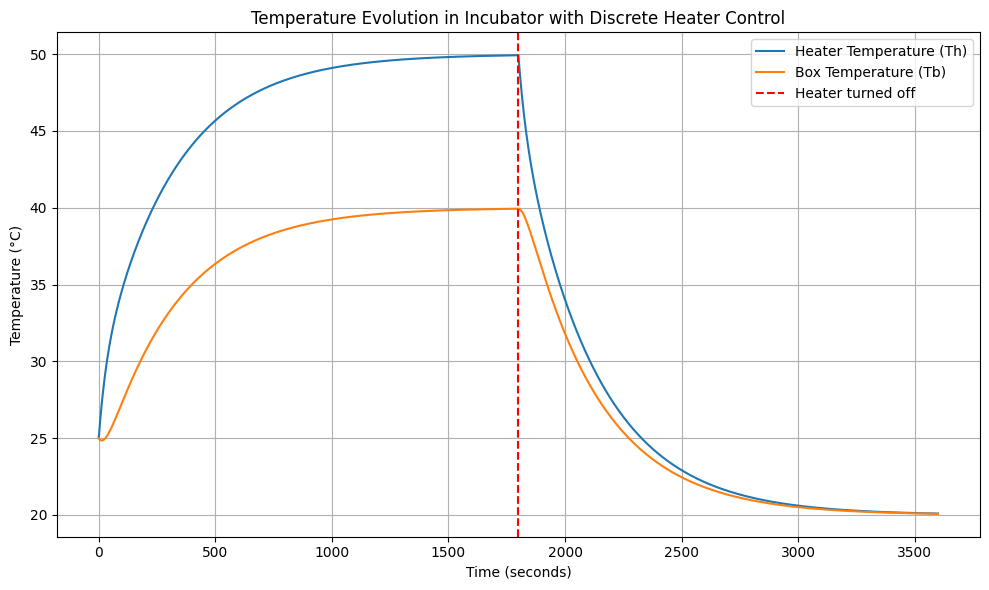

In [13]:
# Parameters (arbitrary values for demonstration purposes)
Ch = 500.0  # Heat capacity of the heater (J/Kg/C)
Cb = 1000.0  # Heat capacity of the box (J/Kg/C)
Ph = 100.0  # Power supplied to the heater (W)
G_hb = 10.0  # Heat transfer coefficient between heater and box (W/C)
G_br = 5.0  # Heat transfer coefficient between box and room (W/C)
Tr = 20.0  # Room temperature (C). For this simulation we assume it is constant.
# Initial conditions
T_h0 = 25.0  # Initial heater temperature (C)
T_b0 = 25.0  # Initial box temperature (C)

incubator_fmu = IncubatorFMU(Ch, Cb, Ph, G_hb, G_br, Tr, T_h0, T_b0)

# Define the simulation parameters
t_start = 0.0
t_end = 3600.0  # Simulate for 1 hour (3600 seconds)
time_step = 3.0  # Step size for each segment of the simulation. Think of this as the execution interval of the controller that turns on and off the heater.

incubator_fmu.fmi2Instantiate()
incubator_fmu.fmi2SetupExperiment(t_start, t_end)
incubator_fmu.fmi2EnterInitializationMode()

incubator_fmu.H_h = 0 # Heater initially off

incubator_fmu.fmi2ExitInitializationMode()

# Arrays to store the results
t_values = []
Th_values = []
Tb_values = []

# Boolean switch for heater (turn on for the first half of the time span, off later)
def heater_switch(t):
    return 1 if t < 1800 else 0

# While-loop simulation with discrete heater switching
current_time = t_start

# Store the initial values
t_values.append(current_time)
Th_values.append(incubator_fmu.getTh())
Tb_values.append(incubator_fmu.getTb())

while current_time < t_end:
    # Define the next time point for the step
    next_time = min(current_time + time_step, t_end)
    
    # Check the state of the heater switch. E.g., you could execute the controller state machine at this point.
    H_h = heater_switch(current_time)
    
    # Set the inputs to the FMU
    incubator_fmu.H_h = H_h

    # Solve the ODE over this small time window
    incubator_fmu.fmi2DoStep(current_time, next_time-current_time)
    
    # Store the results
    t_values.append(next_time)
    Th_values.append(incubator_fmu.getTh())
    Tb_values.append(incubator_fmu.getTb())
    
    # Update the current time
    current_time = next_time

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_values, Th_values, label='Heater Temperature (Th)')
plt.plot(t_values, Tb_values, label='Box Temperature (Tb)')
plt.axvline(x=1800, color='r', linestyle='--', label='Heater turned off')
plt.title('Temperature Evolution in Incubator with Discrete Heater Control')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Now we can get the controller FMU from the previous notebook (note that the code may have changed slightly):

In [14]:
class ControllerFMU:
    """
    A simple implementation of an FMU in Python for co-simulation.
    This FMU represents a thermostat controller with the states: Heating, and Cooling.
    The system adjusts the temperature based on the current room temperature, target temperature, and max temperature.
    """

    def __init__(self, max_temp, min_temp):
        # Initial state
        self.state = "Heating"
        self.heater_on = True
        self.time = 0.0  # Simulation start time

        # Temperature variables
        self.current_temp = 20.0  # Initial room temperature (Celsius)
        self.max_temp = max_temp  # Maximum allowed temperature (Celsius)
        self.min_temp = min_temp  # Minimum allowed temperature (Celsius)

    def fmi2Instantiate(self):
        """
        Simulate the FMU instantiation, which allocates resources and prepares the FMU.
        """
        self.time = 0.0
        self.state = "Heating"
        self.current_temp = 20.0

    def getHeaterSwitch(self):
        return 1 if self.heater_on else 0

    def fmi2SetupExperiment(self, start_time, stop_time):
        """
        Setup the simulation experiment.
        """
        self.time = start_time

    def fmi2EnterInitializationMode(self):
        """
        FMU enters initialization mode. This is where initial conditions would be set.
        """

    def fmi2ExitInitializationMode(self):
        """
        FMU exits initialization mode and is ready to start the simulation.
        """

    def fmi2DoStep(self, current_time, step_size):
        """
        Perform one simulation step. This simulates the thermostat's state machine.
        """
        # Update the simulation time
        self.time = current_time + step_size

        # State machine logic
        if self.state == "Heating":
            if self.current_temp >= self.max_temp:
                self.state = "Cooling" 
                self.heater_on = False

        elif self.state == "Cooling":
            if self.current_temp < self.min_temp:
                self.state = "Heating" 
                self.heater_on = True

    def fmi2Terminate(self):
        """
        Terminate the FMU simulation and free resources.
        """

Now the two FMUs can be coupled in the following co-simulation:

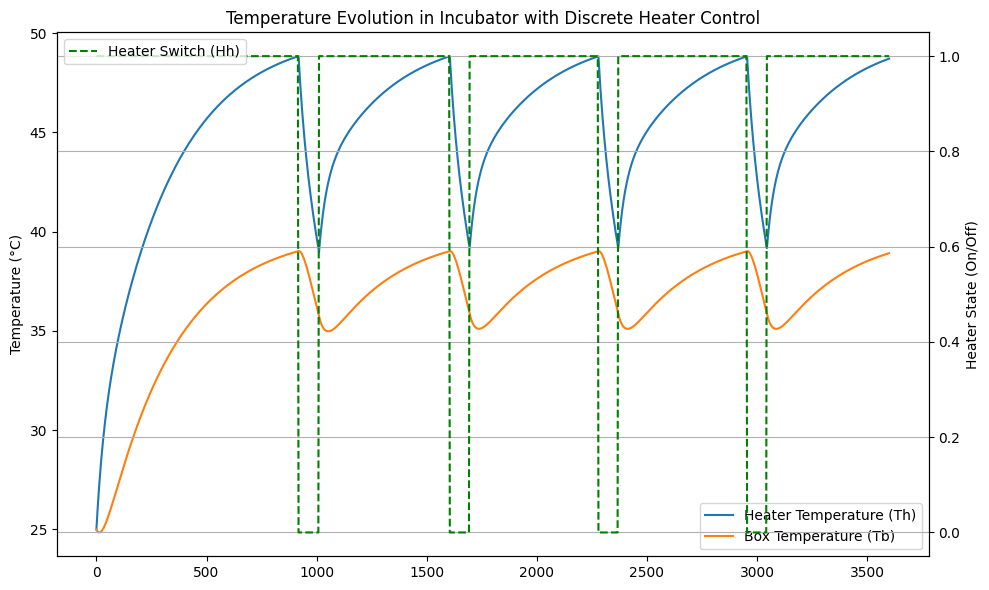

In [20]:
# Parameters (arbitrary values for demonstration purposes)
Ch = 500.0  # Heat capacity of the heater (J/Kg/C)
Cb = 1000.0  # Heat capacity of the box (J/Kg/C)
Ph = 100.0  # Power supplied to the heater (W)
G_hb = 10.0  # Heat transfer coefficient between heater and box (W/C)
G_br = 5.0  # Heat transfer coefficient between box and room (W/C)
Tr = 20.0  # Room temperature (C). For this simulation we assume it is constant.
# Initial conditions
T_h0 = 25.0  # Initial heater temperature (C)
T_b0 = 25.0  # Initial box temperature (C)

max_temp = 39.0 # Max temperature for controller (C)
min_temp = 36.0 # Min temperature for controller (C)

incubator_fmu = IncubatorFMU(Ch, Cb, Ph, G_hb, G_br, Tr, T_h0, T_b0)
controller_fmu = ControllerFMU(max_temp, min_temp)

# Define the simulation parameters
t_start = 0.0
t_end = 3600.0  # Simulate for 1 hour (3600 seconds)
time_step = 3.0  # Step size for each segment of the simulation. Think of this as the execution interval of the controller that turns on and off the heater.

incubator_fmu.fmi2Instantiate()
incubator_fmu.fmi2SetupExperiment(t_start, t_end)
incubator_fmu.fmi2EnterInitializationMode()

controller_fmu.fmi2Instantiate()
controller_fmu.fmi2SetupExperiment(t_start, t_end)
controller_fmu.fmi2EnterInitializationMode()

incubator_fmu.H_h = 0 # Heater initially off

incubator_fmu.fmi2ExitInitializationMode()
controller_fmu.fmi2ExitInitializationMode()

# Arrays to store the results
t_values = []
Th_values = []
Tb_values = []
Hh_values = []

# While-loop simulation with discrete heater switching
current_time = t_start

# Store the initial values
t_values.append(current_time)
Th_values.append(incubator_fmu.getTh())
Tb_values.append(incubator_fmu.getTb())
Hh_values.append(controller_fmu.getHeaterSwitch())

while current_time < t_end:
    # Define the next time point for the step
    next_time = min(current_time + time_step, t_end)

    # Set the inputs to the FMUs
    controller_fmu.current_temp = incubator_fmu.getTb()
    incubator_fmu.H_h = controller_fmu.getHeaterSwitch()

    # Solve the ODE over this small time window
    incubator_fmu.fmi2DoStep(current_time, next_time-current_time)
    
    # Execute controller
    controller_fmu.fmi2DoStep(current_time, next_time-current_time)

    # Store the results
    t_values.append(next_time)
    Th_values.append(incubator_fmu.getTh())
    Tb_values.append(incubator_fmu.getTb())
    Hh_values.append(controller_fmu.getHeaterSwitch())
    
    # Update the current time
    current_time = next_time

# Plot the results
# Plot the results with Hh_values on a secondary y-axis
plt.figure(figsize=(10, 6))

# Plot the temperatures on the primary y-axis
plt.plot(t_values, Th_values, label='Heater Temperature (Th)')
plt.plot(t_values, Tb_values, label='Box Temperature (Tb)')

plt.ylabel('Temperature (°C)')

plt.legend()

# Plot the heater switch on the secondary y-axis
plt.twinx()  # Create a second y-axis
plt.plot(t_values, Hh_values, label='Heater Switch (Hh)', color='green', linestyle='--')
plt.ylabel('Heater State (On/Off)')

# Labels and title
plt.title('Temperature Evolution in Incubator with Discrete Heater Control')
plt.xlabel('Time (seconds)')

# Grid, legend, and layout
plt.grid(True)
plt.legend(loc='upper left')  # Adjust legend position
plt.tight_layout()
plt.show()
